This colab notebook is the mini-project which will be 

In [0]:
import torch 
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data
import numpy as np

from torch.autograd import Variable
from matplotlib import pyplot as plt

torch.set_default_tensor_type('torch.cuda.FloatTensor')
device = 'cuda'

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!
Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
           )
Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
           )



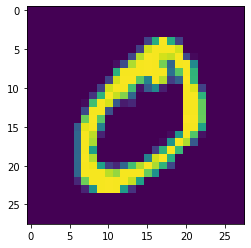

In [0]:
#We will load the MNIST dataset here.

transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

train_data = torchvision.datasets.MNIST(root = './data', train = True, download = True, transform = transform )

test_data = torchvision.datasets.MNIST(root = './data',train = False ,download = True,  transform = transform)

 

print(train_data)
print(test_data)

plt.imshow(np.asarray(train_data[1][0].reshape(28,28)))



In [0]:
BATCH_SIZE = 32
train_loader = torch.utils.data.DataLoader (train_data, batch_size = BATCH_SIZE, )
test_loader = torch.utils.data.DataLoader (test_data, batch_size = 1, )

# train_loader.to('cuda')
# test_loader.to('cuda')


print(train_loader)

We will define our network in the following cell. There are several ways of doing this in PyTorch, but in this example we will do it by subclassing nn.module.

Our network will have 4 convolutional layers followed by 2 fully-connected layers.


In [0]:
class MyConvNet(nn.Module):
  def __init__(self):
    super(MyConvNet, self).__init__()
    self.conv1 = nn.Conv2d(1, 32, kernel_size = 3) #Only black and while input channel.
    self.conv2 = nn.Conv2d(32, 64, kernel_size = 3)
    self.conv3 = nn.Conv2d(64, 64, kernel_size = 5)
    self.conv4 = nn.Conv2d(64, 64, kernel_size = 5)

    self.dense1 = nn.Linear(64*3*3, 128)
    self.dense2 = nn.Linear(128, 10)

  def forward (self, x):
    x = F.relu(self.conv1(x))
    x = F.relu(self.conv2(x))

    x = F.relu(F.max_pool2d(self.conv3(x), 2))
    x = F.relu(F.max_pool2d(self.conv4(x), 2))

    x = x.view(-1, 3*3*64)
    x = F.relu(self.dense1(x))
    x = F.relu(self.dense2(x))

    return F.softmax(x, dim = 1)    


In [0]:
#Setting few things up

net = MyConvNet()
net.to('cuda')
print(net)
tld = iter(train_loader)
im = next(tld)[0].to(device)
print (net.forward(im))


MyConvNet(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv4): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1))
  (dense1): Linear(in_features=576, out_features=128, bias=True)
  (dense2): Linear(in_features=128, out_features=10, bias=True)
)
tensor([[0.1023, 0.0979, 0.0979, 0.0980, 0.0993, 0.0979, 0.0979, 0.1062, 0.1045,
         0.0979],
        [0.1022, 0.0979, 0.0979, 0.0981, 0.0992, 0.0979, 0.0979, 0.1062, 0.1048,
         0.0979],
        [0.1022, 0.0980, 0.0980, 0.0981, 0.0993, 0.0980, 0.0980, 0.1061, 0.1045,
         0.0980],
        [0.1025, 0.0979, 0.0979, 0.0981, 0.0994, 0.0979, 0.0979, 0.1060, 0.1046,
         0.0979],
        [0.1023, 0.0979, 0.0979, 0.0980, 0.0994, 0.0979, 0.0979, 0.1060, 0.1047,
         0.0979],
        [0.1024, 0.0979, 0.0979, 0.0981, 0.0994, 0.0979, 0.0979, 0.1060, 0.1045,
         0.0979],
        [0.1024, 0.09

In [0]:
def test(model, test_loader):
    correct = 0 
    for test_imgs, test_labels in test_loader:
        test_imgs = Variable(test_imgs).to(device)
        output = model(test_imgs)
        predicted = torch.max(output,axis = 1).indices
        correct += (predicted == test_labels).sum()
        # print(predicted, test_labels)
        # print(correct)
    print("Test accuracy:{:.3f}% ".format( float(correct * 100) / (len(test_loader))))


def train(model, train_loader, EPOCHS = 6, lossF = None):
  if lossF == None:
    lossF = nn.CrossEntropyLoss()
  optim = torch.optim.Adam (model.parameters(), lr = 4e-4, weight_decay=1e-3)
  model.train()
  for epoch in range(EPOCHS):
    correct = 0
    for batch_idx, (X_batch, y_batch) in enumerate(train_loader):
      var_X_batch = Variable(X_batch).to(device)
      var_y_batch = Variable(y_batch).to(device)
      # print(var_X_batch.size())
      output = model(var_X_batch)

      # print(output)
      # print(output.size(), var_y_batch.size())
      loss = lossF (output, var_y_batch)
      loss.backward()
      optim.step()
      optim.zero_grad()

      predicted = torch.max(output.data, axis = 1).indices
      # print(predicted)
      correct += (predicted == var_y_batch).sum()

      if (batch_idx % 200) == 0:
          print('Epoch : {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\t Accuracy:{:.3f}%'.format(
                    epoch, batch_idx*len(X_batch), len(train_loader.dataset), 100.*batch_idx / len(train_loader), loss.item(), float(correct*100) / float(BATCH_SIZE*(batch_idx+1))))




In [0]:
train (net, train_loader)

Epoch : 0 [0/60000 (0%)]	Loss: 1.488319	 Accuracy:96.875%
Epoch : 0 [6400/60000 (11%)]	Loss: 1.502229	 Accuracy:98.912%
Epoch : 0 [12800/60000 (21%)]	Loss: 1.468827	 Accuracy:98.854%
Epoch : 0 [19200/60000 (32%)]	Loss: 1.494073	 Accuracy:98.825%
Epoch : 0 [25600/60000 (43%)]	Loss: 1.461303	 Accuracy:98.896%
Epoch : 0 [32000/60000 (53%)]	Loss: 1.487499	 Accuracy:98.870%
Epoch : 0 [38400/60000 (64%)]	Loss: 1.494469	 Accuracy:98.863%
Epoch : 0 [44800/60000 (75%)]	Loss: 1.462196	 Accuracy:98.842%
Epoch : 0 [51200/60000 (85%)]	Loss: 1.489333	 Accuracy:98.802%
Epoch : 0 [57600/60000 (96%)]	Loss: 1.492449	 Accuracy:98.782%
Epoch : 1 [0/60000 (0%)]	Loss: 1.491289	 Accuracy:96.875%
Epoch : 1 [6400/60000 (11%)]	Loss: 1.479921	 Accuracy:99.036%
Epoch : 1 [12800/60000 (21%)]	Loss: 1.490141	 Accuracy:98.862%
Epoch : 1 [19200/60000 (32%)]	Loss: 1.461366	 Accuracy:98.918%
Epoch : 1 [25600/60000 (43%)]	Loss: 1.461505	 Accuracy:98.970%
Epoch : 1 [32000/60000 (53%)]	Loss: 1.462684	 Accuracy:98.954%
Epoc

In [0]:
test(net, test_loader)

Test accuracy:98.860% 


Let's try to hallucinate 7 from our trained network and see what happens. For this we will need to change the network slightly.



In [0]:
def train_im(model, train_loader, digit = 7 ,iters = 1000, lossF = None):
  im = torch.zeros_like(train_data[1][0]).view(1, 1, 28, 28).to(device)
  im = Variable(im, requires_grad = True)
  digit = Variable(torch.tensor(digit)).to(device).view(1)
  if lossF == None:
    lossF = nn.CrossEntropyLoss()
  optim = torch.optim.Adam ([im, ], lr = 4e-3, weight_decay=1e-3)
  model.train()
  im_history = []
  for it in range(iters):
    
    output = model(im)
    # print(output)
    loss = lossF (output, digit)
    loss.backward()
    optim.step()
    optim.zero_grad()

    
    # if (it % 200) == 0:
    #     print('Epoch : {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\t Accuracy:{:.3f}%'.format(
    #               epoch, batch_idx*len(X_batch), len(train_loader.dataset), 100.*batch_idx / len(train_loader), loss.item(), float(correct*100) / float(BATCH_SIZE*(batch_idx+1))))

  return im

In [0]:
im = train_im (net, train_loader, digit=7)

In [0]:
im = np.asarray(im.view(28, 28).cpu().detach())


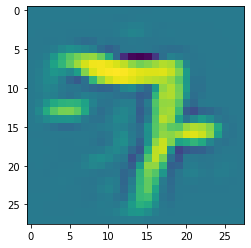

In [0]:
plt.imshow(im)

In the cell below we will hallucinate all the digits from 0 to 9 each for 1000 iterations and will print the results.

0


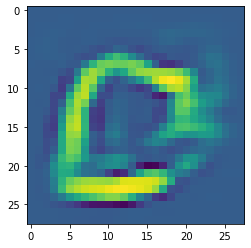

1


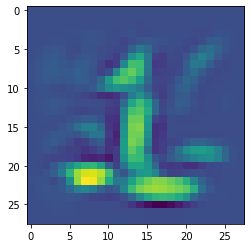

2


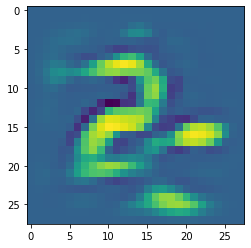

3


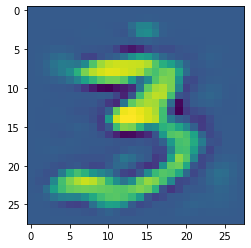

4


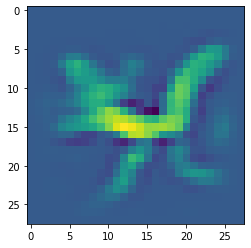

5


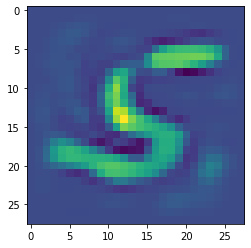

6


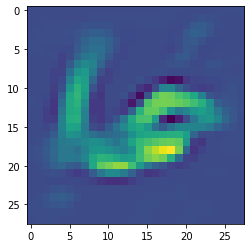

7


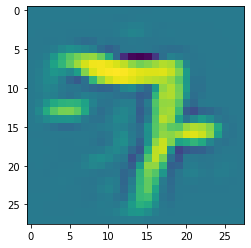

8


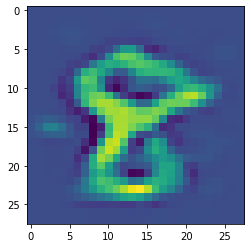

9


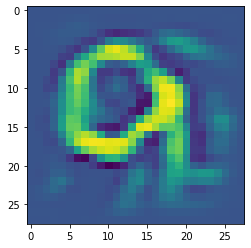

In [0]:
for i in range (10):
  im = train_im (net, train_loader, digit=i)
  im = np.asarray(im.view(28, 28).cpu().detach())
  print (i)
  plt.imshow(im)
  plt.show()